# Exploratory data analaysis for IPC data

## Set export to True if you wish to export graphs and tables


In [80]:
export = True
seed = 1337


In [81]:
from sklearn.cluster import KMeans
import warnings
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
import matplotlib.dates as mdate
from os import listdir
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from auxiliary_code.helper_functions import *
from auxiliary_code.Clustering import Clustering

warnings.simplefilter('ignore')

In [82]:
df_phase_fews_net = pd.read_csv(
    '../datasets/fews_net_ipc.csv', parse_dates=['date'])
set_index(df_phase_fews_net)

df_ipc = pd.read_csv('../datasets/ipc_processed.csv',
                     parse_dates=['date'], usecols=['date', 'area', 'area_phase'])
set_index(df_ipc)

df_phase = pd.concat([df_ipc, df_phase_fews_net])

df_hum = pd.read_csv(
    '../datasets/humantarian_assistance.csv', parse_dates=['date'])
set_index(df_hum)

df_pop = pd.read_csv(
    '../datasets/world_bank_processed.csv', parse_dates=['date'], usecols=['date', 'area', 'pop'])
set_index(df_pop)

df_pop = df_pop.groupby('area').mean()

df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')


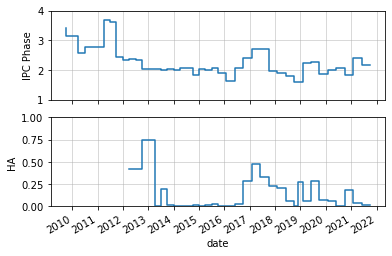

In [84]:
fig, ax = plt.subplots(nrows=2, sharex=True)


df_plot_phase = df_phase_fews_net.merge(df_pop, left_index=True,
                               right_index=True)

df_plot_hum = df_hum.merge(df_pop, left_index=True,
                           right_index=True)

target = df_plot_phase['area_phase'].unstack()
weights = df_plot_phase['pop'].unstack()
norm_weights = weights / weights.sum()
(target * norm_weights).sum().plot(drawstyle='steps-pre', ax=ax[0])

target = df_plot_hum['hum_assistance'].unstack()
weights = df_plot_hum['pop'].unstack()
norm_weights = weights / weights.sum()
(target * norm_weights).sum().plot(drawstyle='steps-pre', ax=ax[1])

ax[0].set_yticks(range(1, 5))
ax[1].set_yticks(np.arange(0, 1.25, .25))


ax[0].set_ylim(1, 4)
ax[1].set_ylim(0, 1)

ax[0].grid(True, alpha=.6)
ax[1].grid(True, alpha=.6)

ax[0].set_ylabel('IPC Phase')
ax[1].set_ylabel('HA')
ax[0].set_xlabel('Date')


locator = mdate.YearLocator()

ax[0].xaxis.set_major_locator(locator)
ax[1].xaxis.set_major_locator(locator)
plt.minorticks_off()

if export:
    fig.savefig('../figures/pop_weighted_ipc_time.pdf', format='pdf')


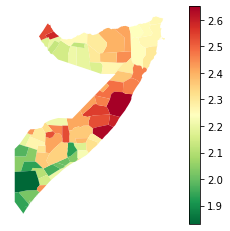

In [5]:
fig, ax = plt.subplots()

df_mean_phase_area = df_phase.groupby('area')['area_phase'].mean()
df_plot_phase = df_shape.merge(
    df_mean_phase_area, left_index=True, right_index=True)
df_plot_phase.plot(column='area_phase', cmap='RdYlGn_r', legend=True, ax=ax)
ax.axis('off')

if export:
    fig.savefig('../Figures/mean_phase_per_area.pdf',
                dpi=300, bbox_inches='tight', format='pdf')


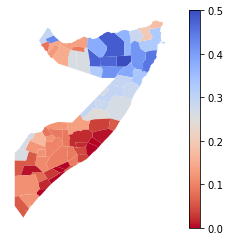

In [6]:
fig, ax = plt.subplots()

df_mean_phase_area = df_hum.groupby('area')['hum_assistance'].mean()
df_plot_phase = df_shape.merge(
    df_mean_phase_area, left_index=True, right_index=True)
df_plot_phase.plot(column='hum_assistance',
                   cmap='coolwarm_r', legend=True, ax=ax, vmin=0, vmax=0.5)
ax.axis('off')

if export:
    fig.savefig('../Figures/mean_hum_per_area.pdf',
                dpi=300, bbox_inches='tight', format='pdf')


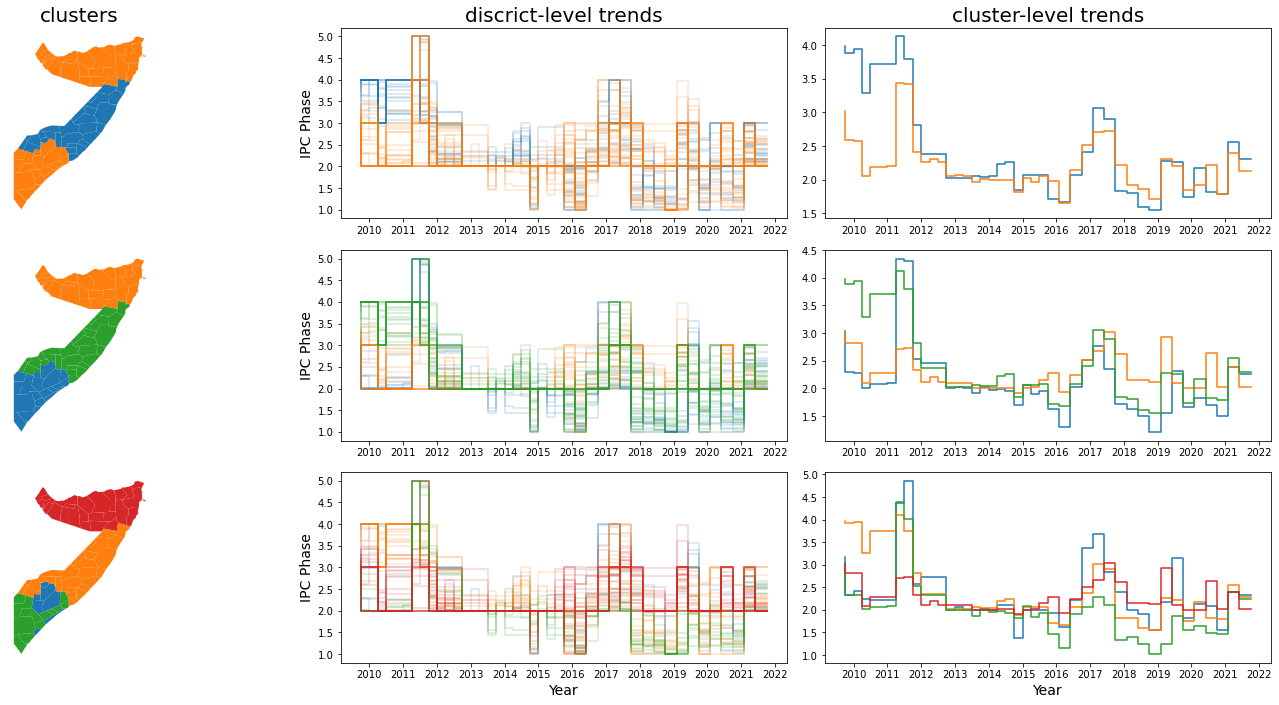

In [7]:
df_phase_unstacked = df_phase_fews_net.unstack()
mask = df_phase_unstacked.isna().sum(axis=1) == 0
df_phase_unstacked = df_phase_unstacked[mask]
dates = df_phase_unstacked.columns.get_level_values(1)
areas = df_phase_unstacked.index
values = df_phase_unstacked.to_numpy()

clustering = Clustering(list(range(2, 5)), seed)
fig = clustering.spatial_clustering(areas, values, dates, df_shape, xlab='Year', ylab='IPC Phase', kwargs={'drawstyle': 'steps-pre'})
plt.tight_layout()

if export:
    plt.savefig('../figures/clustering.pdf', format='pdf')


In [12]:
def transition_prob_matrix(phases_old, phases_new):
    fig, ax = plt.subplots()
    old_new = phases_old.merge(phases_new, left_index=True,
                               right_index=True).dropna().to_numpy()

    A = np.zeros((5, 5))
    for i, j in np.round(old_new).astype('int8'):
        A[i - 1, j - 1] += 1

    sns.heatmap(A / A.sum(axis=1).reshape(5, -1),
                annot=True, ax=ax, vmin=0, vmax=0.81)

    ax.set_xticklabels(range(1, 6))
    ax.set_yticklabels(range(1, 6))
    ax.set_xlabel('New IPC phase')
    ax.set_ylabel('Old IPC phase')

    return fig


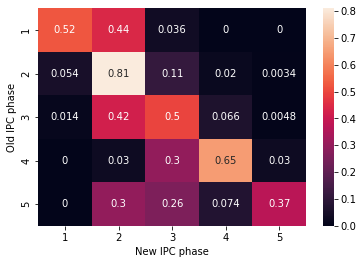

In [13]:
phases_old = df_phase_fews_net.sort_index()[['area_phase']]
phases_new = df_phase_fews_net.sort_index()['area_phase'].shift(-1)
fig = transition_prob_matrix(phases_old, phases_new)

if export:
    fig.savefig('../Figures/phase_transition_matrix_lag_1.pdf', format='pdf')


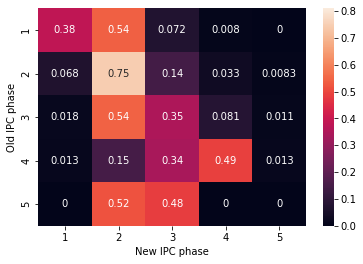

In [20]:
phases_new = df_phase_fews_net.sort_index()['area_phase'].shift(-2)
fig = transition_prob_matrix(phases_old, phases_new)
if export:
    fig.savefig('../Figures/phase_transition_matrix_lag_2.pdf', format='pdf')


In [15]:
counts = np.unique(
    ((df_phase['area_phase']).round().astype(int)), return_counts=True)
df_table = pd.DataFrame(
    {'phase': counts[0], 'frequency': counts[1]/counts[1].sum() * 100})
df_table['frequency'] = df_table['frequency'].round(1).astype(str) + ' %'
df_table.set_index('phase', inplace=True)

if export:
    with open('../tables/phase_freq.tex', 'w') as file:
        file.write(df_table.to_latex())
        
df_table

,frequency
phase,
1,8.1 %
2,65.2 %
3,19.7 %
4,6.3 %
5,0.7 %


In [16]:
df_tab = df_phase.merge(df_pop, left_index=True,
                        right_index=True).copy()
df_tab['area_phase'] = df_tab['area_phase'].round().astype(int)

table = pd.DataFrame({'frequency': np.zeros(5)},
                     index=pd.Series(np.arange(1, 6), name='phase'))

for idx, row in df_tab.iterrows():
    table.loc[row['area_phase']] += row['pop']

table = round(table/table.sum() * 100, 1).astype('str') + ' %'

if export:
    with open('../tables/phase_freq_pop_weighted.tex', 'w') as file:
        file.write(df_table.to_latex())

table


,frequency
phase,
1,8.6 %
2,65.8 %
3,17.8 %
4,6.9 %
5,0.8 %


In [3]:
df_phase_fews_net = pd.read_csv(
    '../datasets/fews_net_ipc.csv', parse_dates=['date'])
set_index(df_phase_fews_net)

df_ipc = pd.read_csv('../datasets/ipc_processed.csv',
                     parse_dates=['date'], usecols=['date', 'area', 'area_phase'])
set_index(df_ipc)


In [63]:
from itertools import product
from sklearn.metrics import confusion_matrix
n_years = get_date(df_phase_fews_net).max().year - get_date(df_phase_fews_net).min().year
n_months = get_date(df_phase_fews_net).max().month - get_date(df_phase_fews_net).min().month
n_months += n_years * 12
months = [get_date(df_phase_fews_net).min() + pd.DateOffset(months=1)*n for n in range(n_months + 1)]
combinations = product(get_area(df_phase_fews_net).unique(), months)
df_upsample = pd.DataFrame(combinations, columns=['area', 'date'])
df_phase_fews_net = df_phase_fews_net.join(df_upsample.set_index(['area', 'date']), how='outer')
df_phase_fews_net.sort_index(inplace=True)
df_phase_fews_net = df_phase_fews_net.groupby('area').apply(lambda x: x.interpolate('linear'))
df_conf = df_phase_fews_net.join(df_ipc['area_phase'].rename('ipc')).dropna(subset='ipc')

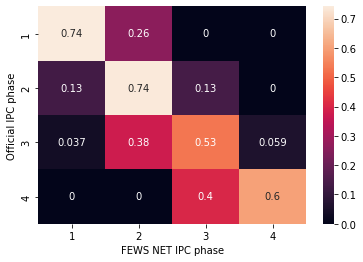

In [78]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(df_conf['ipc'], df_conf['area_phase'].round(), normalize='true'), annot=True)
ax.set_xticklabels(range(1, 5))
ax.set_yticklabels(range(1, 5))
ax.set_ylabel('Official IPC phase')
ax.set_xlabel('FEWS NET IPC phase');

fig.savefig('../figures/confusion_matrix_IPC_FEWS_NET.pdf', format='pdf')